In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_lvq import GlvqModel
from scipy.optimize import minimize
from ceml.backend.jax.costfunctions import CostFunctionDifferentiableJax
import jax.numpy as npx
import warnings
from ceml.sklearn.lvq import LvqCounterfactual, lvq_generate_counterfactual
warnings.filterwarnings("ignore", message="Values in x were outside bounds during a minimize step")


# 1️⃣ Load and preprocess data
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2️⃣ Train GLVQ model with patched optimizer
model = GlvqModel(prototypes_per_class=2, random_state=42)
original_optimize = model._optimize

def patched_optimize(x, y, random_state):
    original_shape = model.w_.shape
    model.w_ = model.w_.ravel()
    original_optimize(x, y, random_state)
    model.w_ = model.w_.reshape(original_shape)

model._optimize = patched_optimize
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
acc = np.mean(y_pred == y_test)
print(f"Accuracy: {acc:.2f}")

(150, 4) (150,)
Accuracy: 0.93


In [3]:
# Custom implementation of the l2-regularization. Note that this regularization is differentiable
class MyRegularization(CostFunctionDifferentiableJax):
    def __init__(self, x_orig):
        self.x_orig = x_orig
        super(MyRegularization, self).__init__()
    
    def score_impl(self, x):
        return npx.sum(npx.square(x - self.x_orig))  # JAX-differentiable L2 regularization

### Dist l2

In [4]:
# 3️⃣ Generate counterfactuals

cf_data = []
sample_indices = range(60)

for idx in sample_indices:
    x_sample = X_test[idx]
    y_orig = model.predict([x_sample])[0]
    y_target=0
    regularization = MyRegularization(x_sample)

    try:
        cf = lvq_generate_counterfactual(
            model,
            x_sample,
            y_target,
            features_whitelist=None,
            dist='l2',
            regularization=regularization,
            C=[0.1, 0.5, 1.0, 10, 100, 1000],
            optimizer='auto',
            optimizer_args={"solver": 'SCS'}
        )
        x_cf = np.array(cf['x_cf'])
        delta = np.array(cf['delta'])
        delta_norm = np.linalg.norm(delta)  # ← Compute Euclidean norm of delta
        y_cf = cf['y_cf']

        cf_data.append({
            'Index': idx,
            'x_orig': x_sample,
            'x_cf': x_cf,
            'delta': delta,
            'delta_norm': delta_norm,  # ← Store it
            'y_orig': y_orig,
            'y_cf': y_cf
        })

        # ✅ Print results
        print(f"\nCounterfactual results for sample index {idx}:")
        print("Original prediction:", y_orig)
        print("Target prediction:  ", y_target)
        print("Counterfactual prediction (y_cf):", y_cf)
        print("Changes applied (delta):", delta)
        print("‖delta‖₂ (Euclidean norm):", delta_norm)

    except Exception as e:
        print(f"Index {idx}: Counterfactual not found ({e})")



Counterfactual results for sample index 0:
Original prediction: 1
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 0.54244447 -1.13796653  0.84321565  0.68465102]
‖delta‖₂ (Euclidean norm): 1.6640232795269267

Counterfactual results for sample index 1:
Original prediction: 0
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [-2.10873627e-09  4.97549006e-08 -8.55312488e-10  1.78032022e-08]
‖delta‖₂ (Euclidean norm): 5.289312314844947e-08

Counterfactual results for sample index 2:
Original prediction: 2
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 1.27220683 -2.6688979   1.97761186  1.60572708]
‖delta‖₂ (Euclidean norm): 3.9026701564972974

Counterfactual results for sample index 3:
Original prediction: 1
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 0.50936721 -1.06857527  0.79179673  0.64290218]
‖delta‖₂ (Euclidean norm): 1.5625534669


Counterfactual results for sample index 17:
Original prediction: 1
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 0.7105966  -0.40247406  0.80307342  0.68493105]
‖delta‖₂ (Euclidean norm): 1.334537511383325

Counterfactual results for sample index 18:
Original prediction: 1
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 0.48873114 -1.02528416  0.75971967  0.6168563 ]
‖delta‖₂ (Euclidean norm): 1.499250276959397

Counterfactual results for sample index 19:
Original prediction: 2
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 0.84897161 -1.78101429  1.31970391  1.07153701]
‖delta‖₂ (Euclidean norm): 2.604337667219659

Counterfactual results for sample index 20:
Original prediction: 0
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [-1.43409742e-08  4.90465393e-08  1.29622313e-09  2.31117330e-08]
‖delta‖₂ (Euclidean norm): 5.609865378247


Counterfactual results for sample index 29:
Original prediction: 0
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [-1.20324040e-08  4.67074864e-08  1.72058523e-09  2.01290342e-08]
‖delta‖₂ (Euclidean norm): 5.2292508675298935e-08

Counterfactual results for sample index 30:
Original prediction: 0
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [-1.65725302e-08  5.15925616e-08  1.25487243e-09  2.57092696e-08]
‖delta‖₂ (Euclidean norm): 5.99915195230212e-08

Counterfactual results for sample index 31:
Original prediction: 0
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [-4.12882065e-09  5.21153964e-08 -1.07011044e-09  2.05057118e-08]
‖delta‖₂ (Euclidean norm): 5.61666365283956e-08

Counterfactual results for sample index 32:
Original prediction: 1
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 0.46406067 -0.97352956  0.72137129  0.58571816


Counterfactual results for sample index 47:
Original prediction: 2
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 0.60375128 -1.26657767  0.93851521  0.76202823]
‖delta‖₂ (Euclidean norm): 1.852088662536684

Counterfactual results for sample index 48:
Original prediction: 1
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 0.50551789 -1.06050069  0.78581619  0.63804372]
‖delta‖₂ (Euclidean norm): 1.550747212382696

Counterfactual results for sample index 49:
Original prediction: 2
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 1.12531312 -0.53851285  1.42627166  1.47070598]
‖delta‖₂ (Euclidean norm): 2.398656425407625

Counterfactual results for sample index 50:
Original prediction: 1
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 0.40504335 -0.84971997  0.62962932  0.51122908]
‖delta‖₂ (Euclidean norm): 1.2425266150844467

Counterfac


Counterfactual results for sample index 58:
Original prediction: 0
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [-1.19980395e-08  5.08214100e-08  4.97029973e-10  2.33573505e-08]
‖delta‖₂ (Euclidean norm): 5.720648147733391e-08

Counterfactual results for sample index 59:
Original prediction: 1
Target prediction:   0
Counterfactual prediction (y_cf): 0
Changes applied (delta): [ 0.58576705 -0.33177199  0.6619986   0.56461012]
‖delta‖₂ (Euclidean norm): 1.1001011048012108


Visualizing 37 counterfactuals...


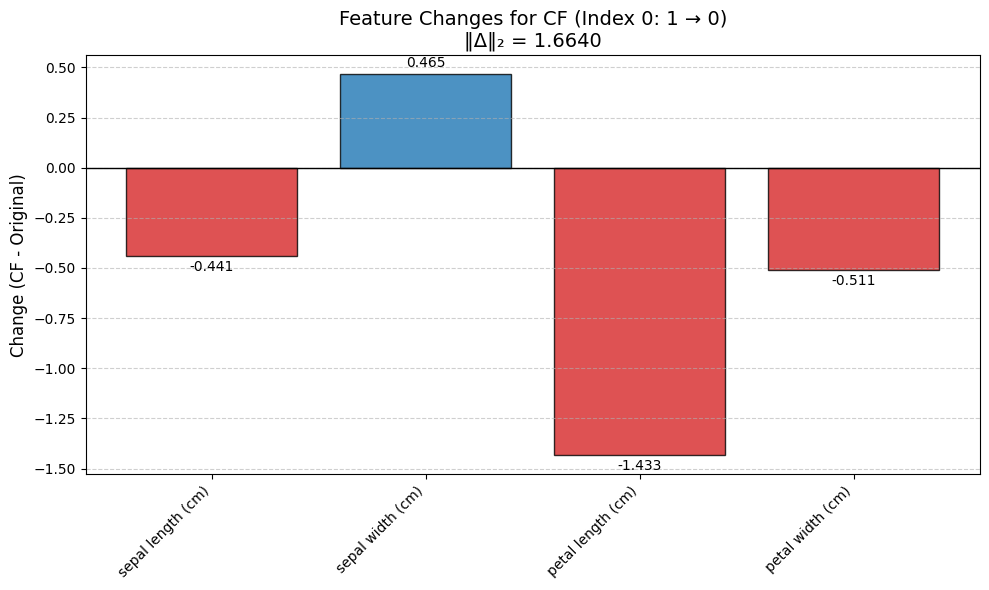

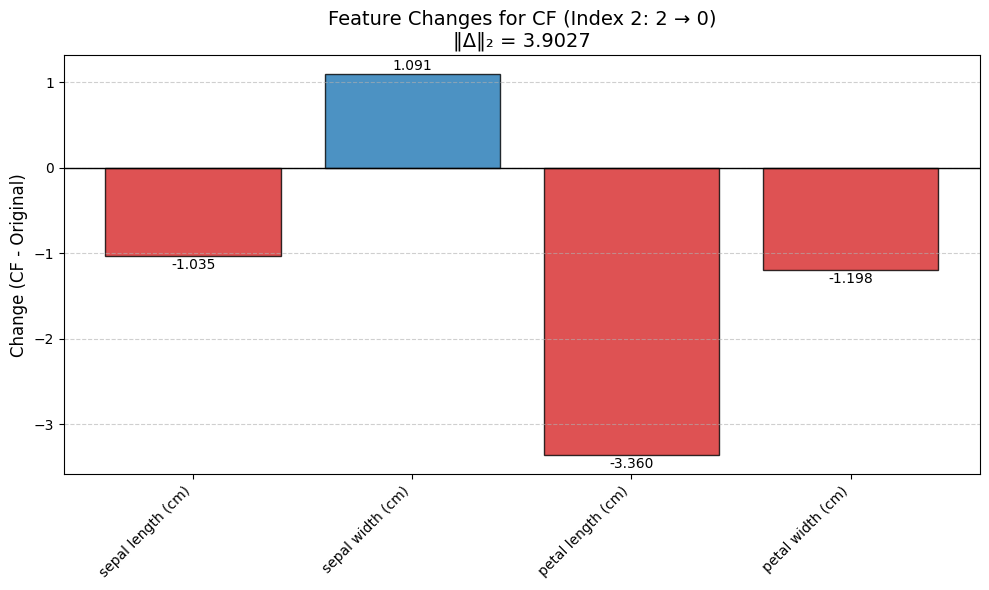

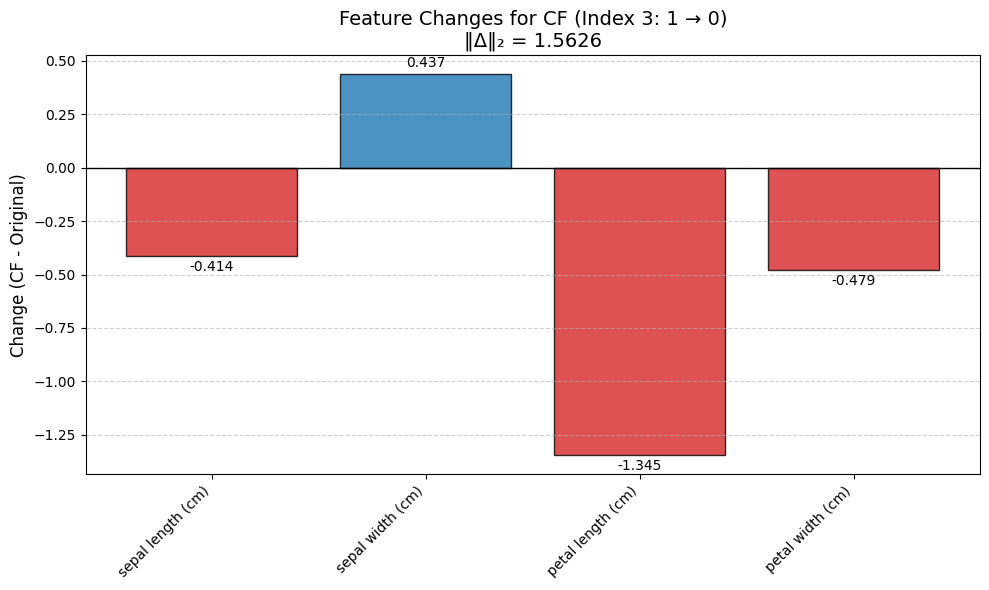

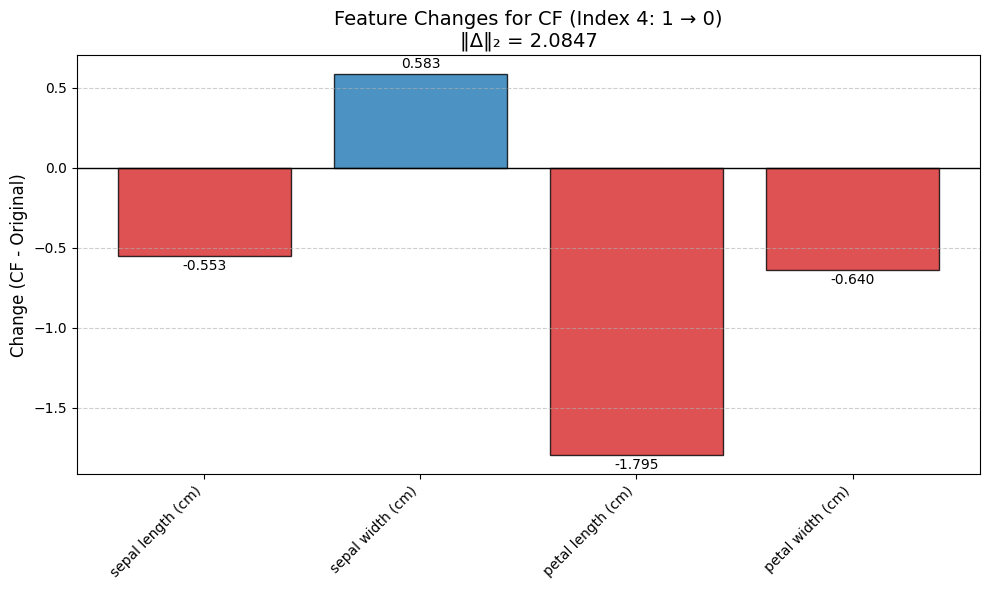

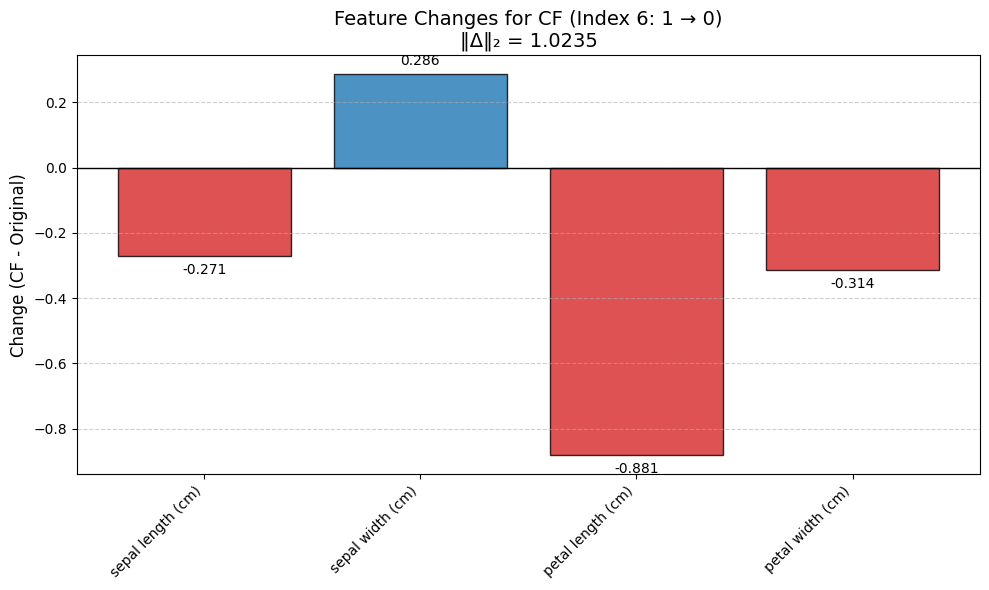

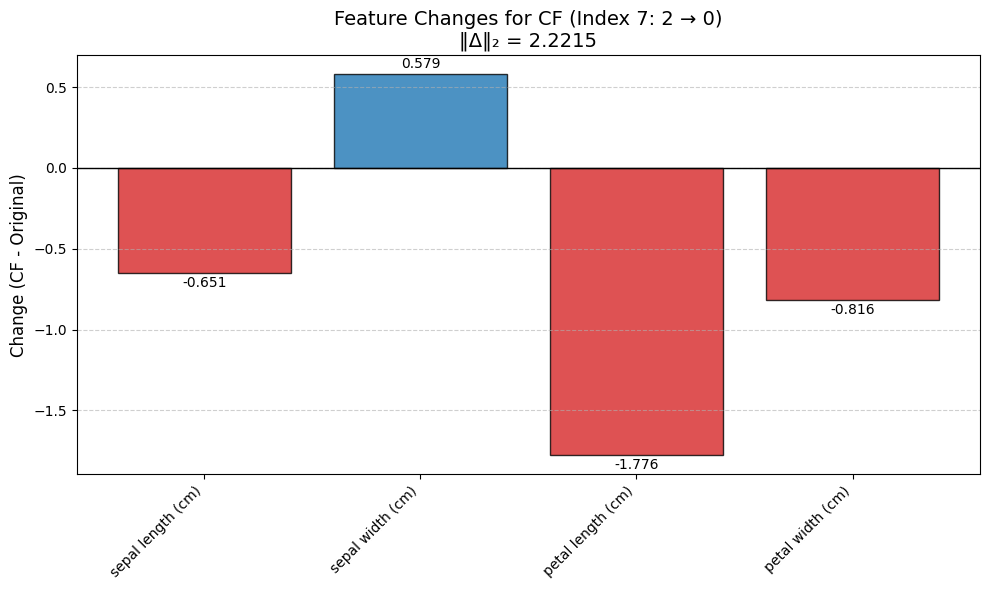

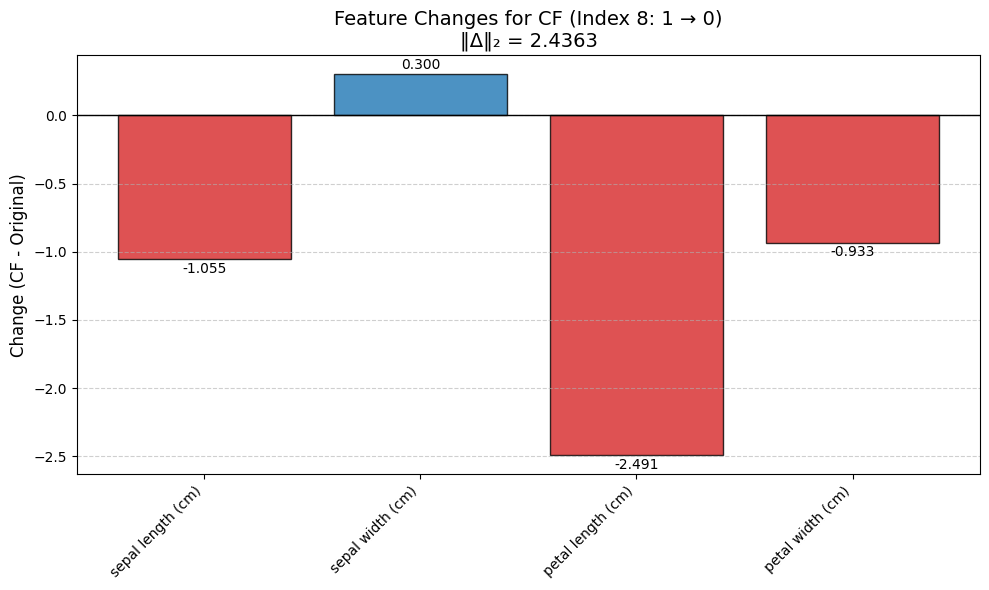

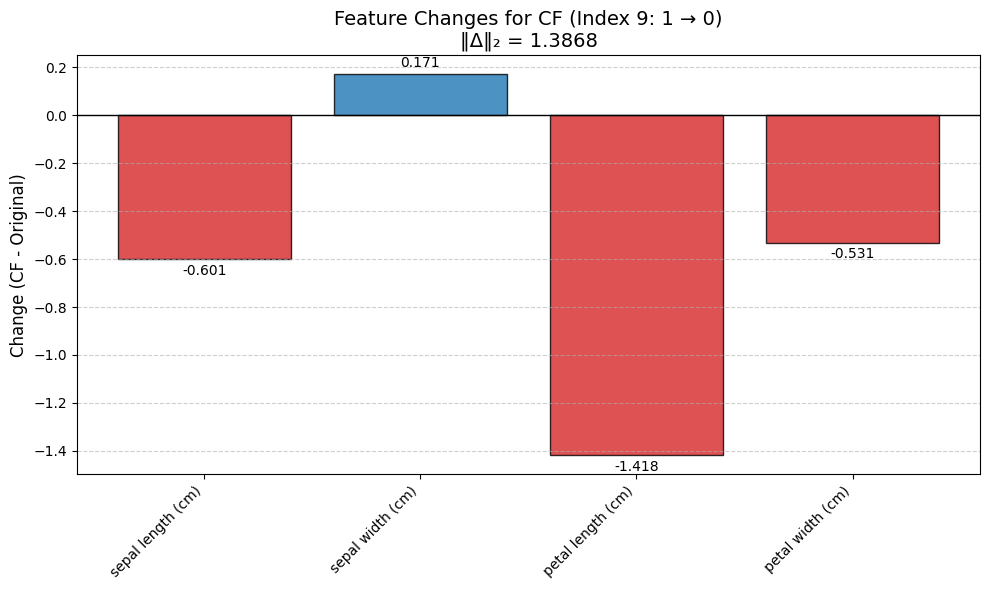

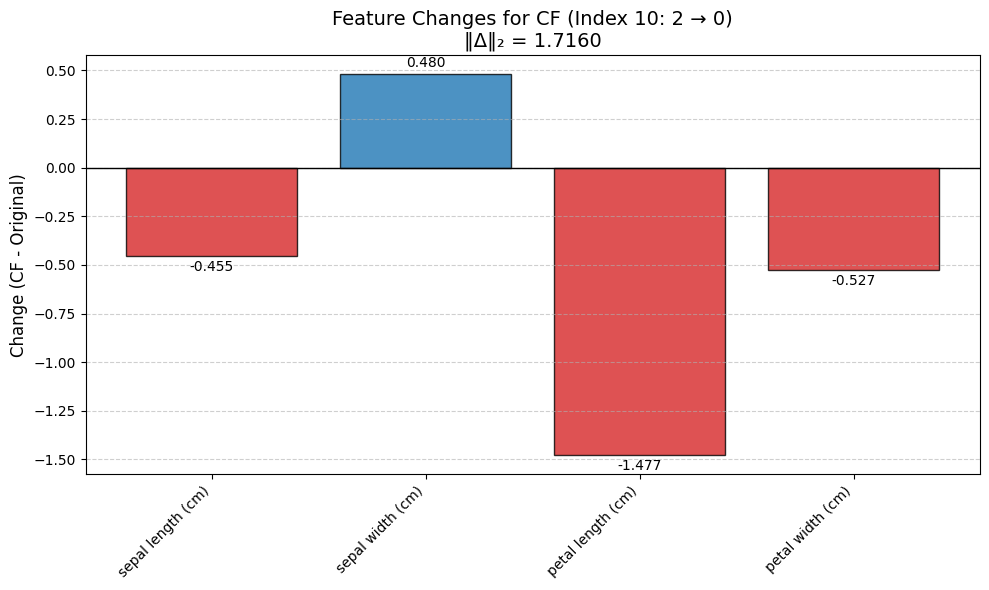

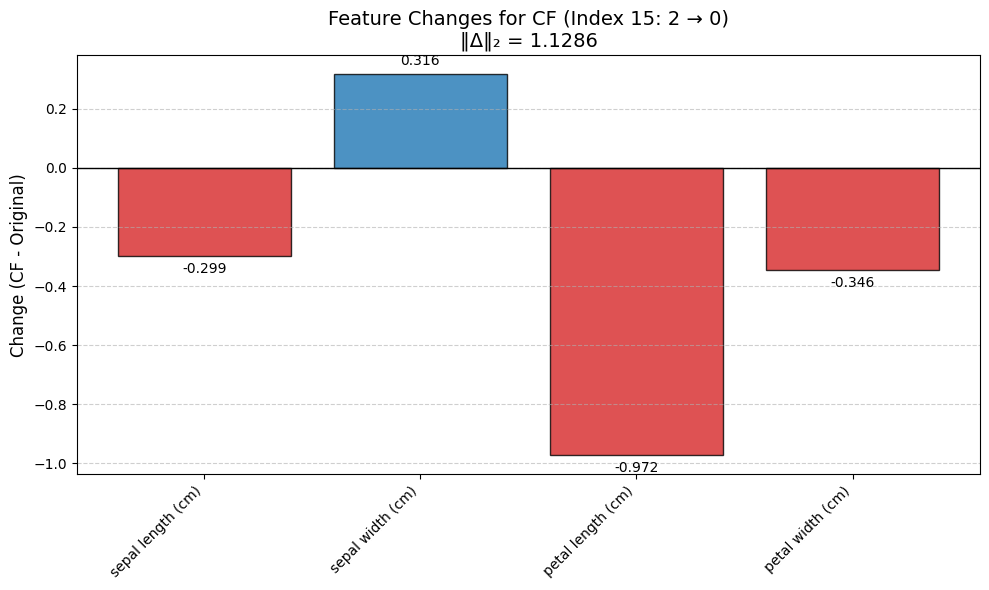

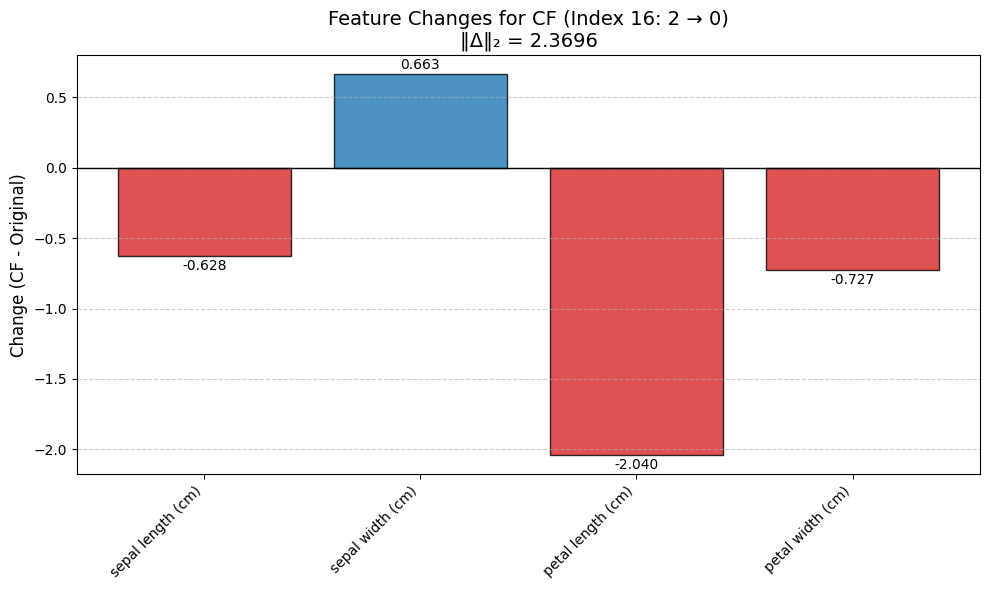

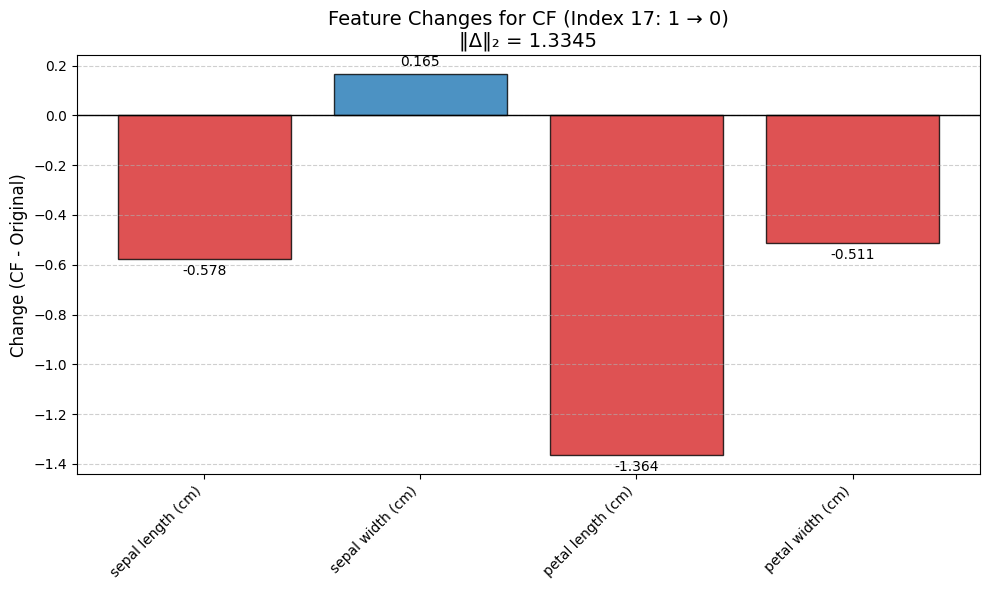

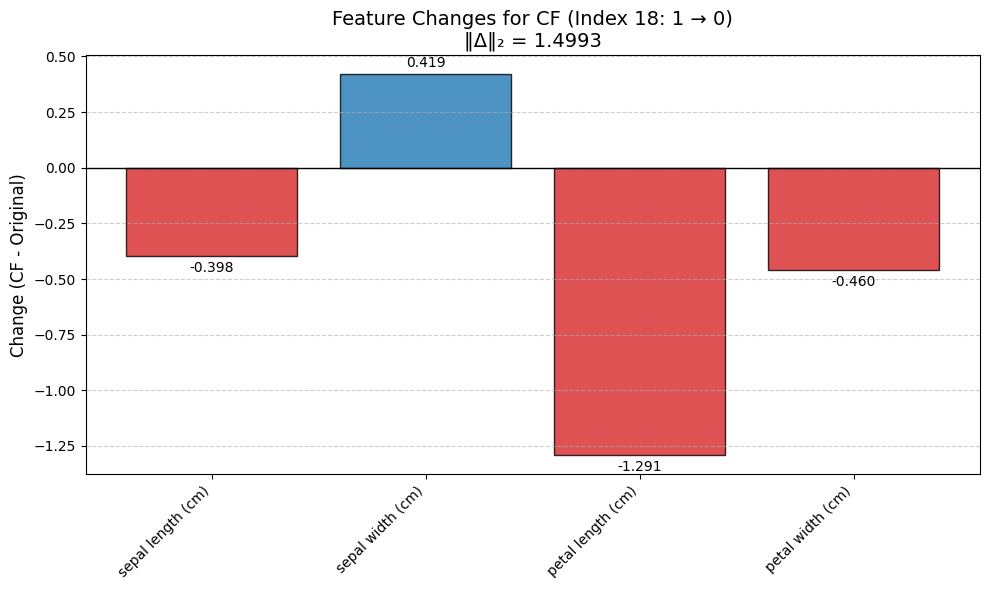

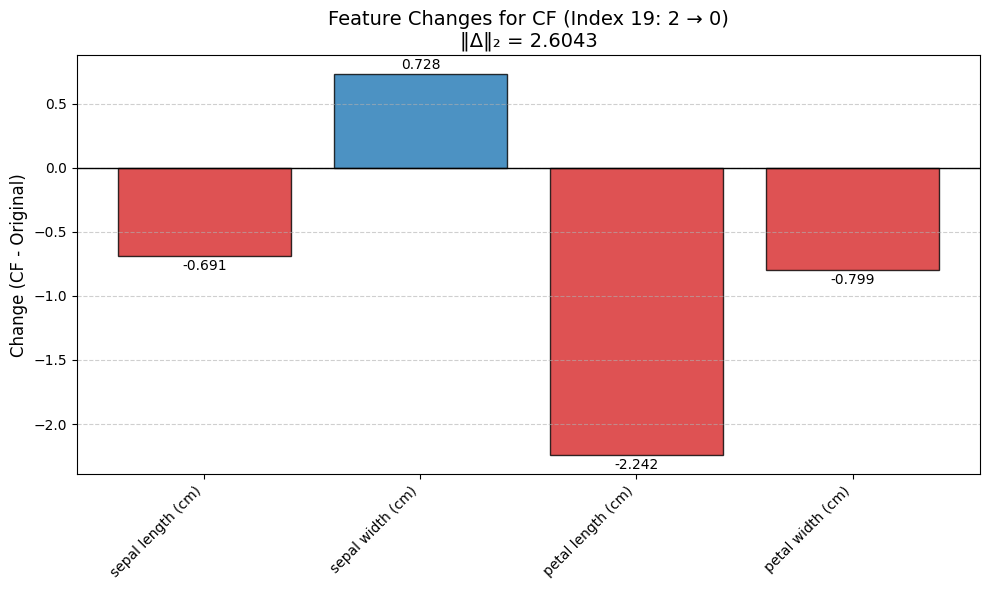

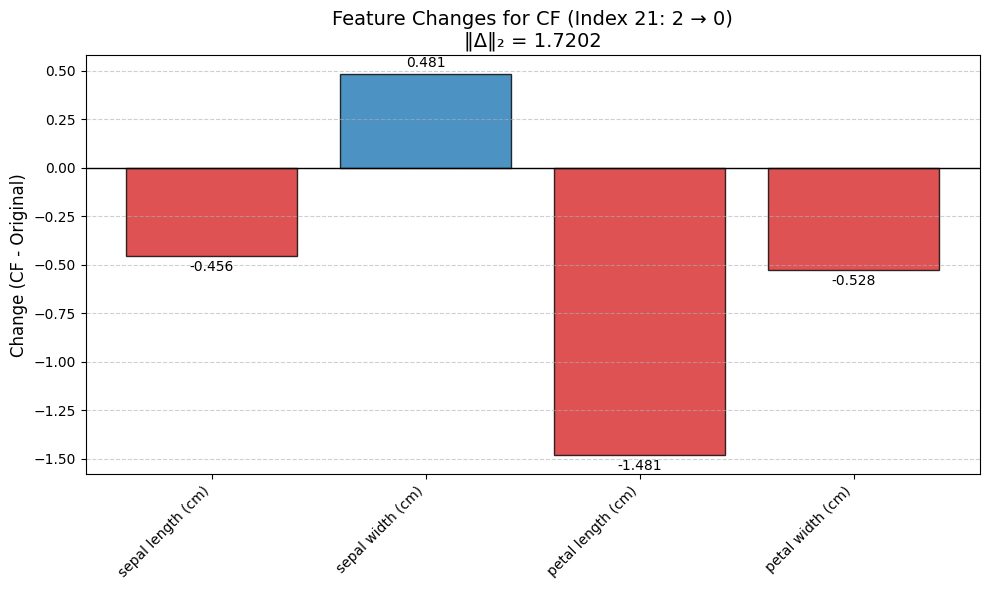

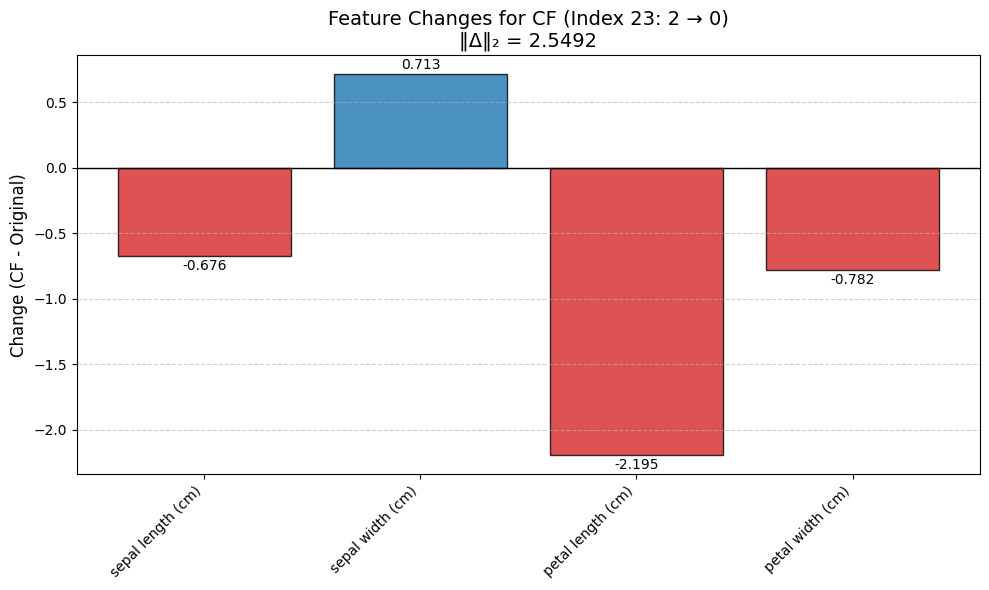

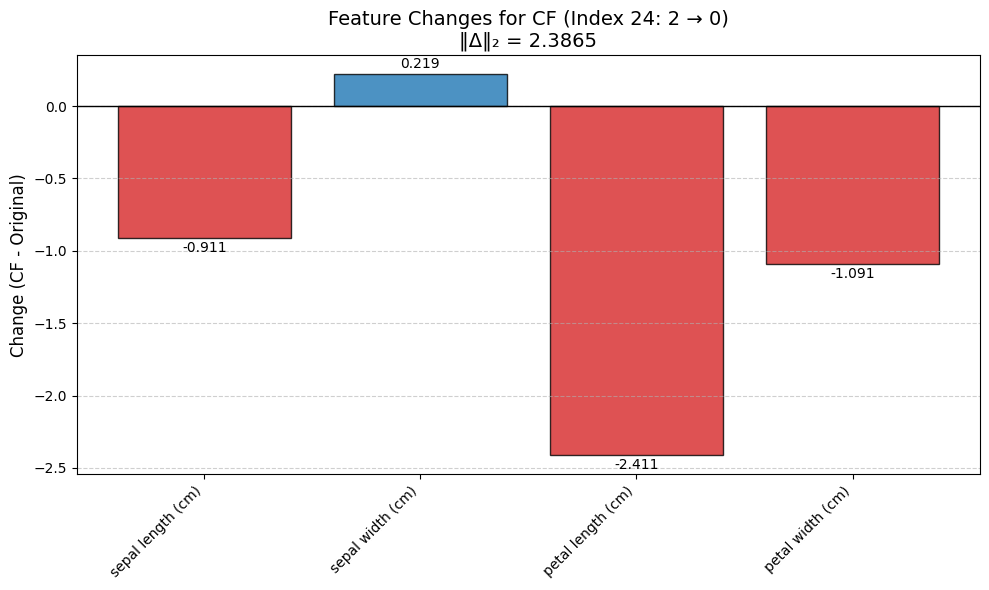

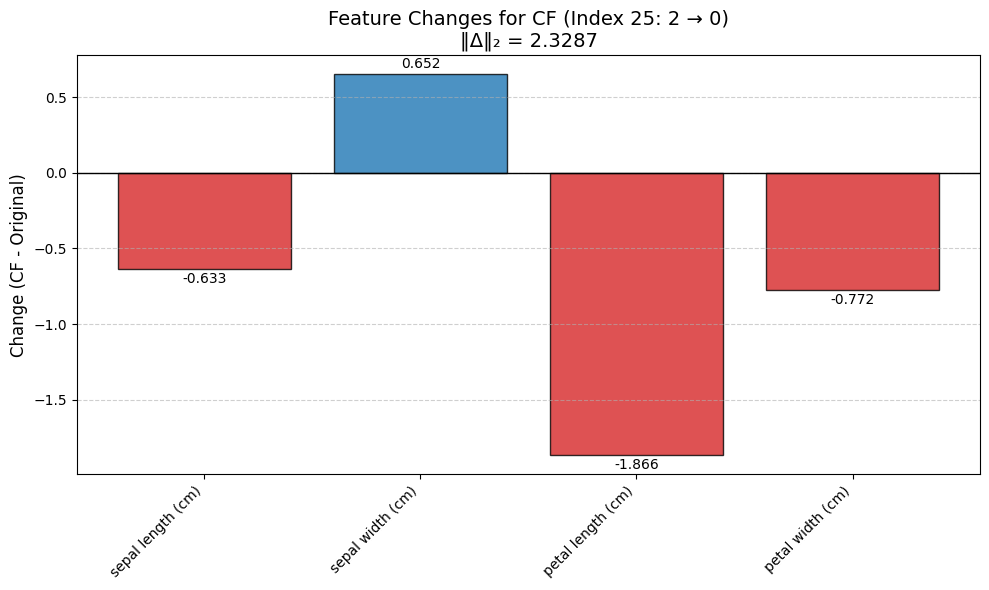

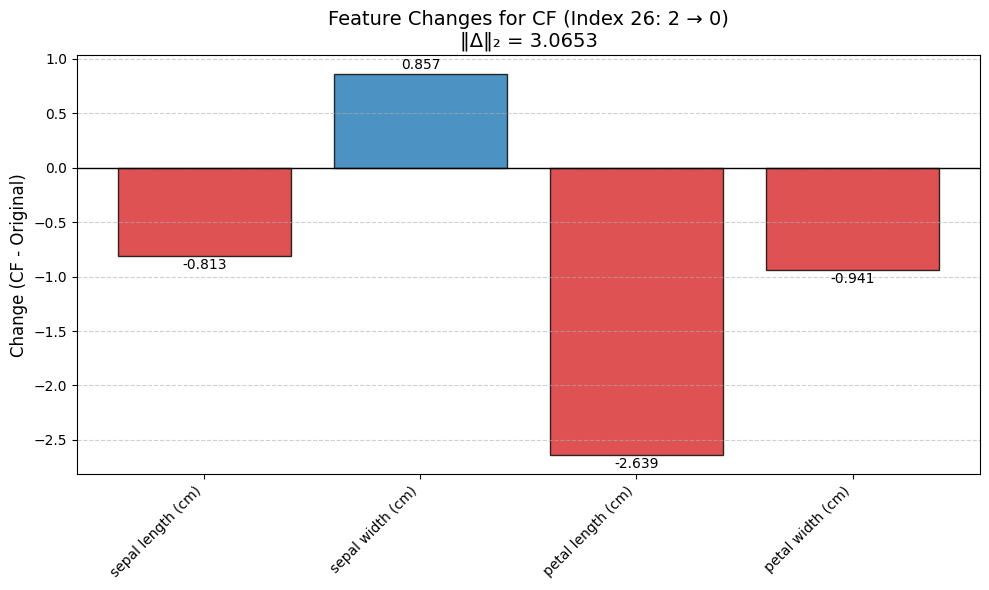

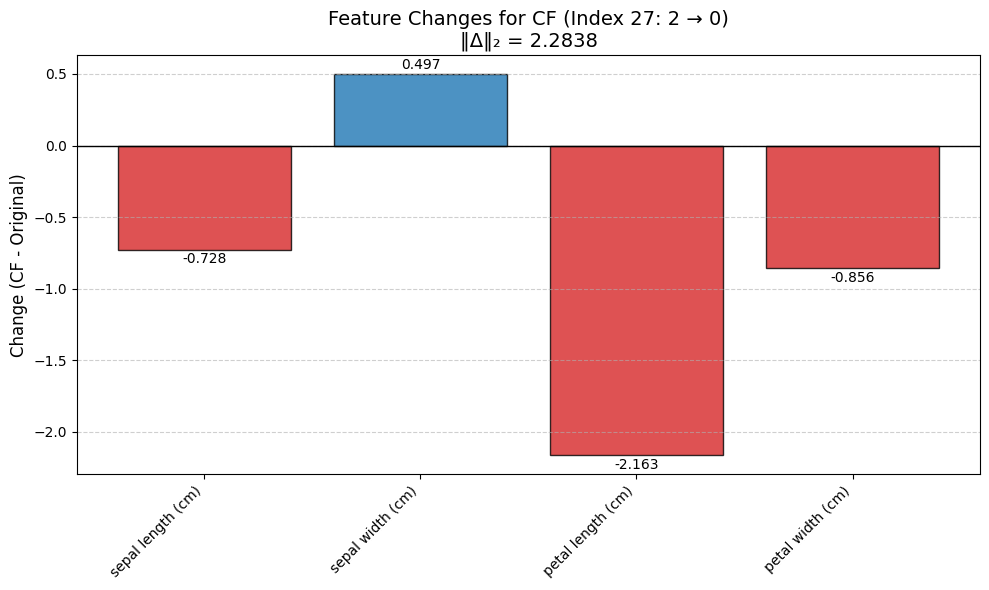

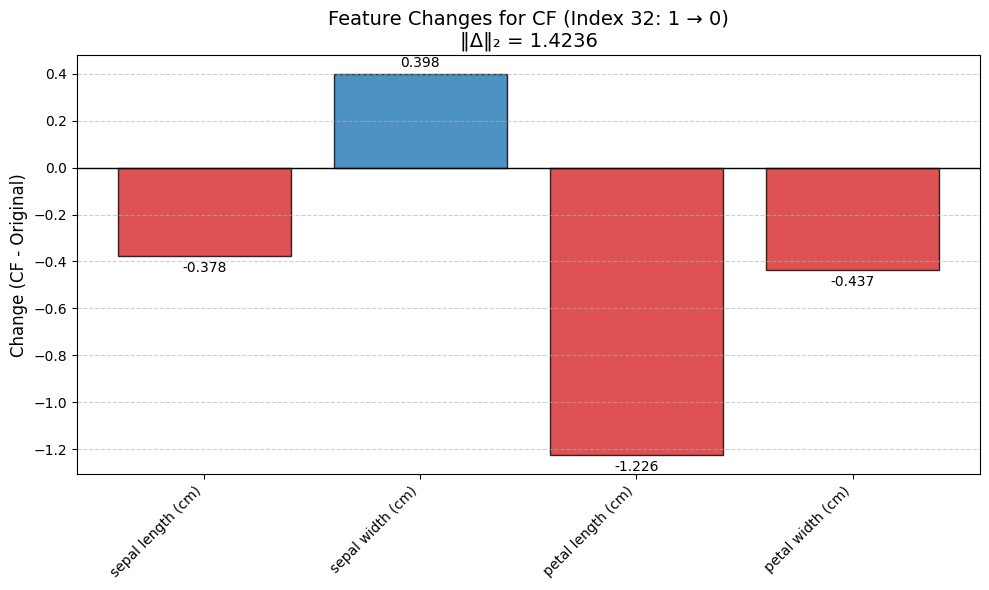

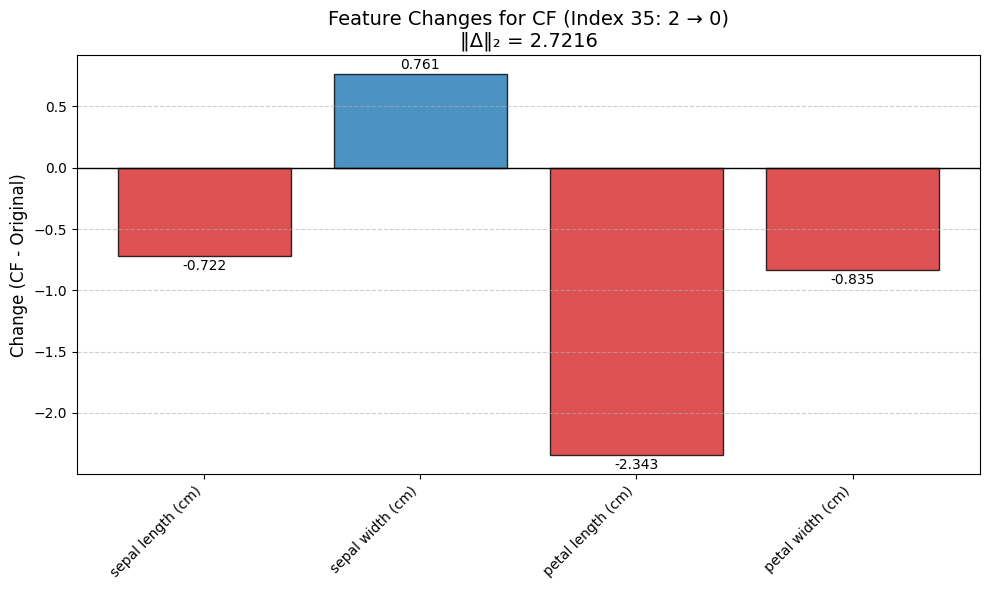

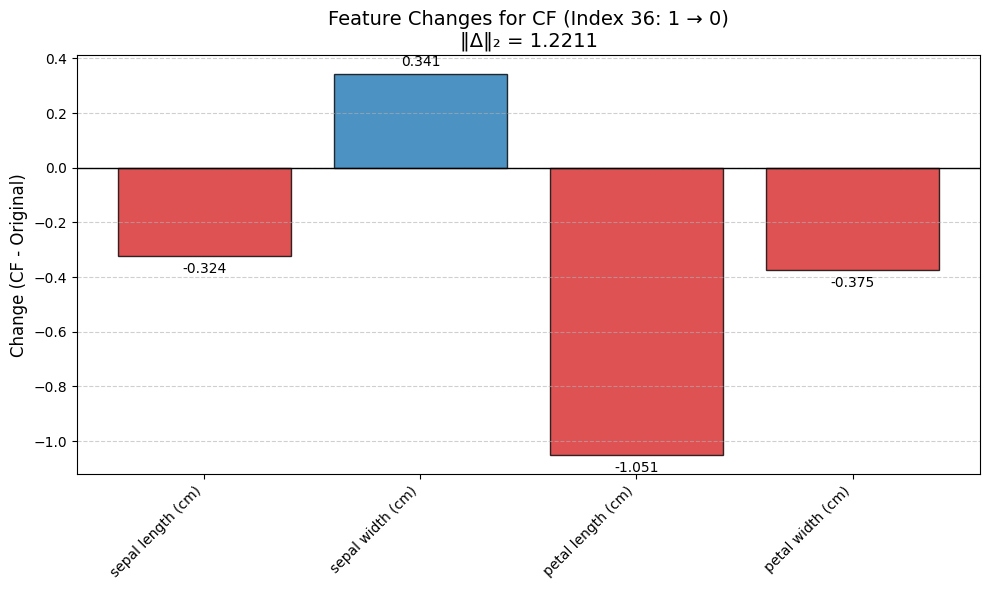

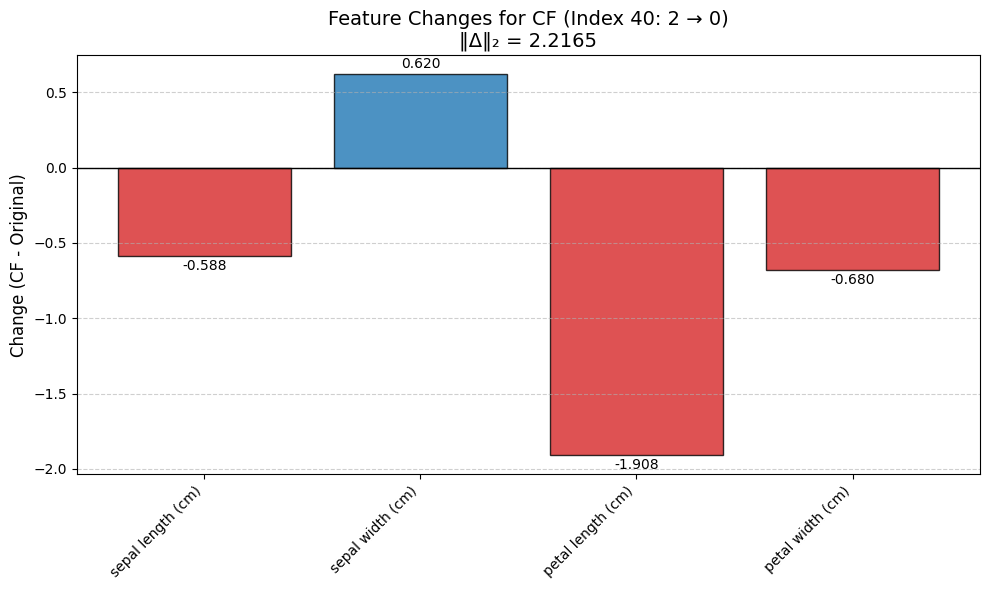

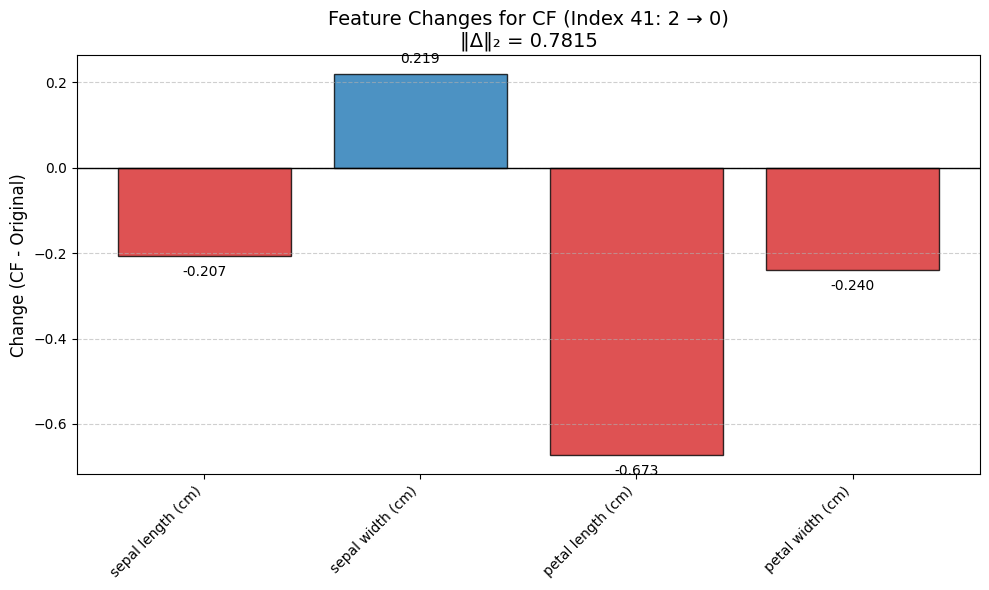

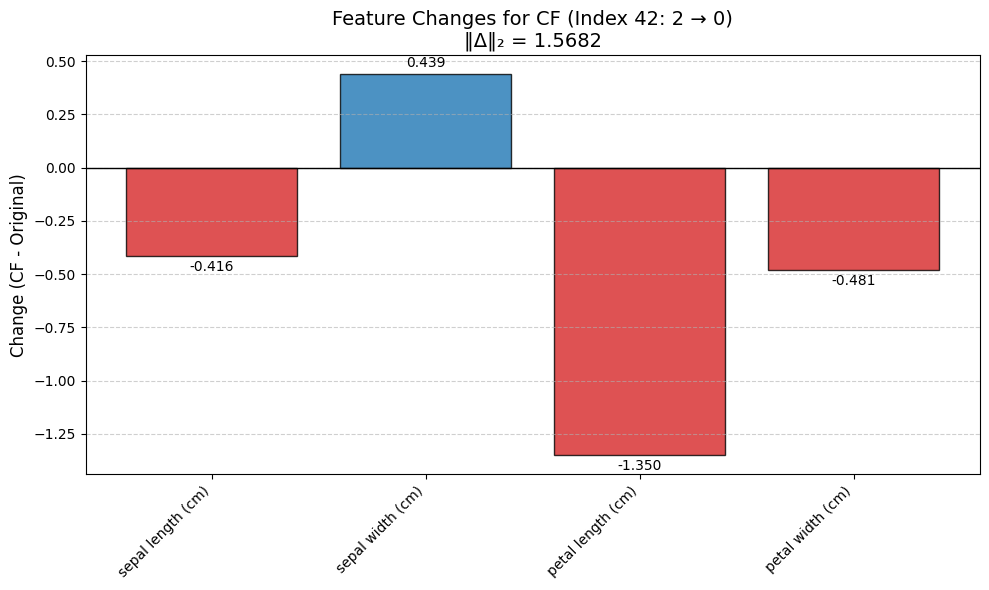

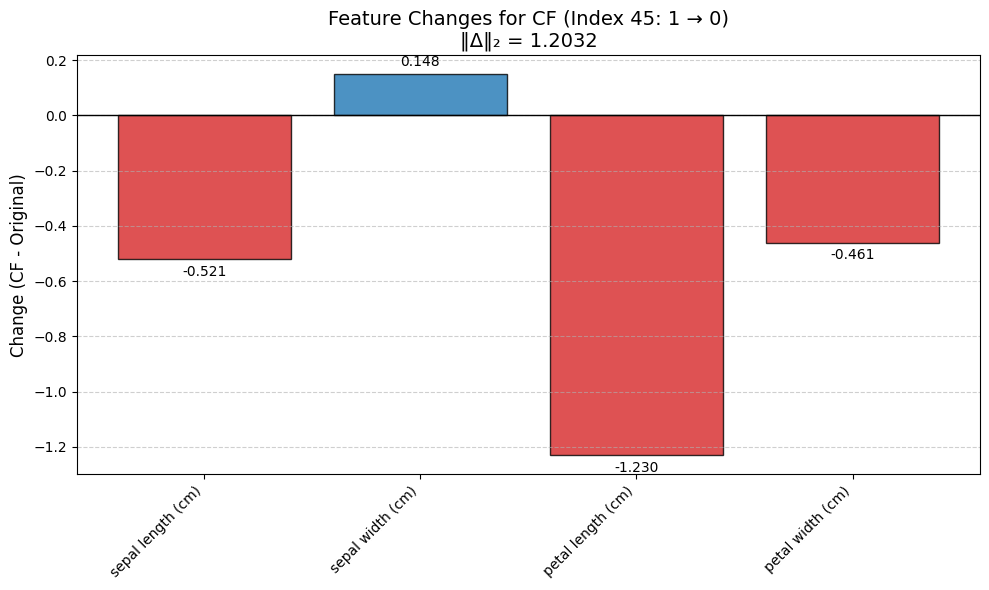

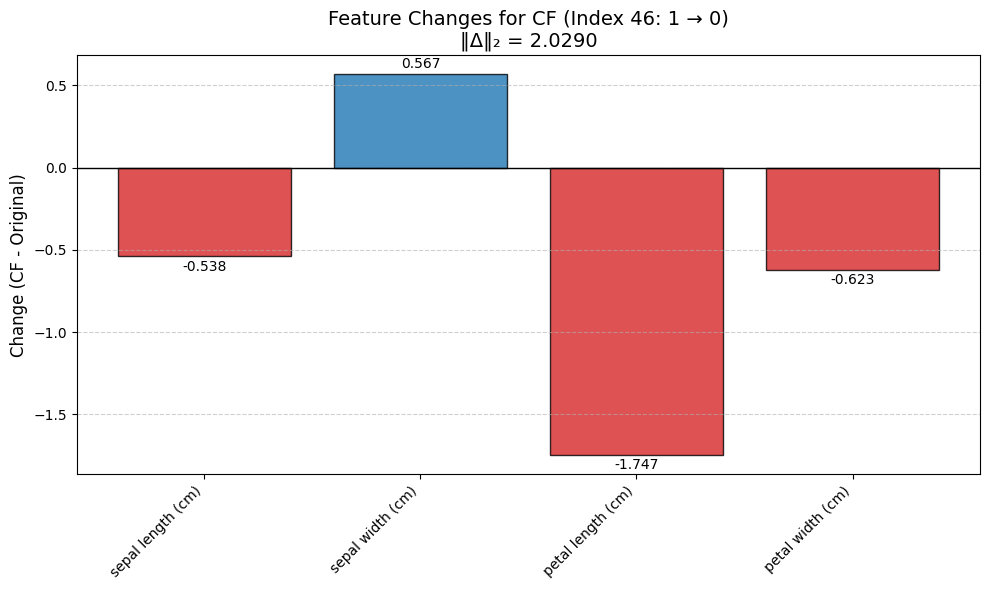

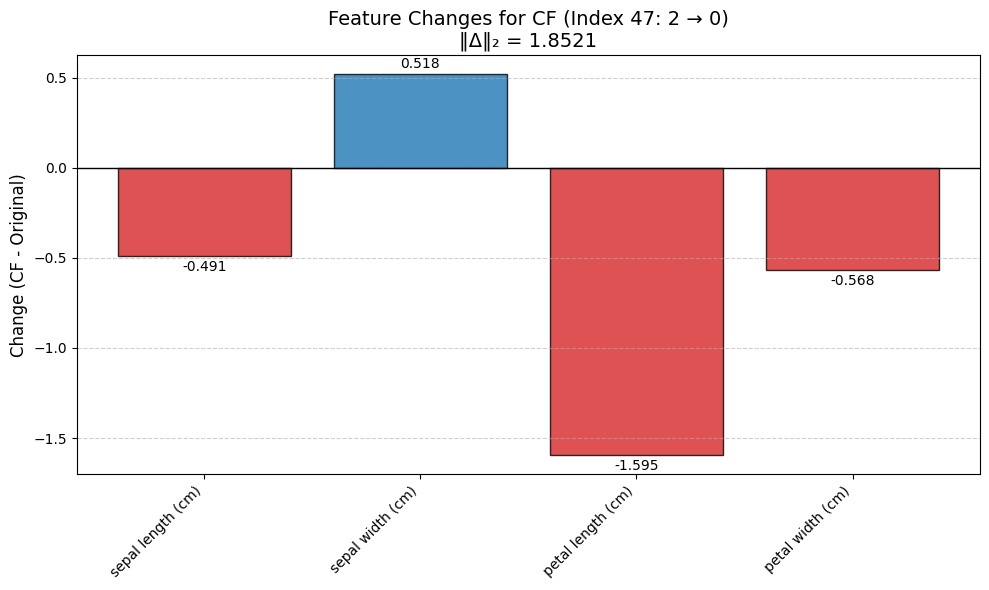

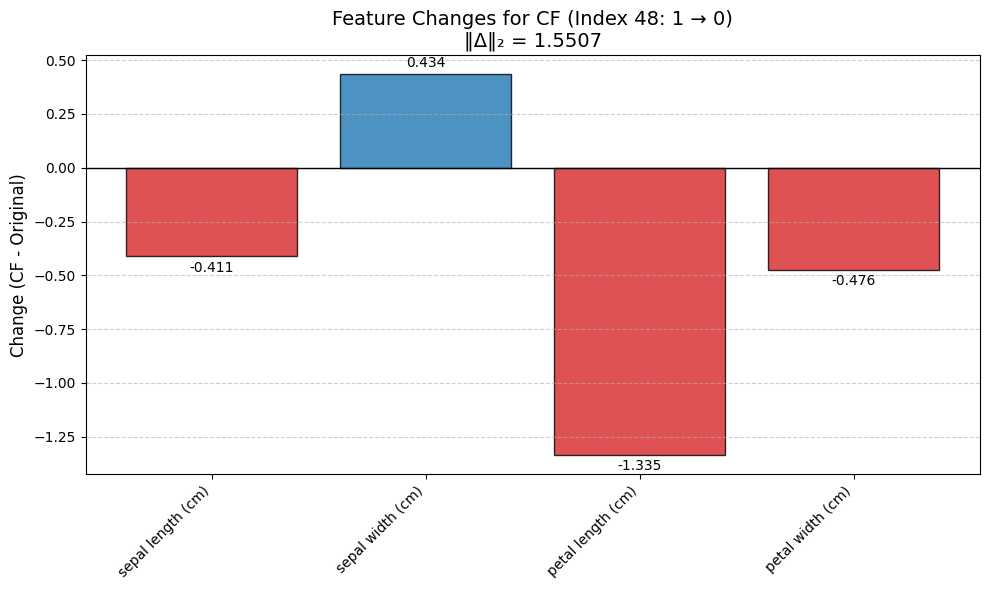

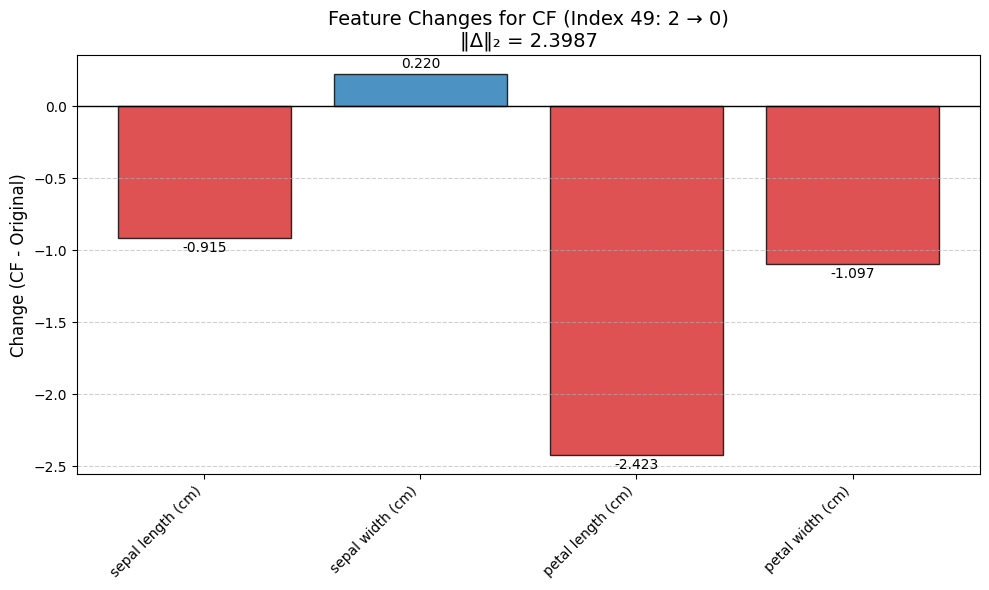

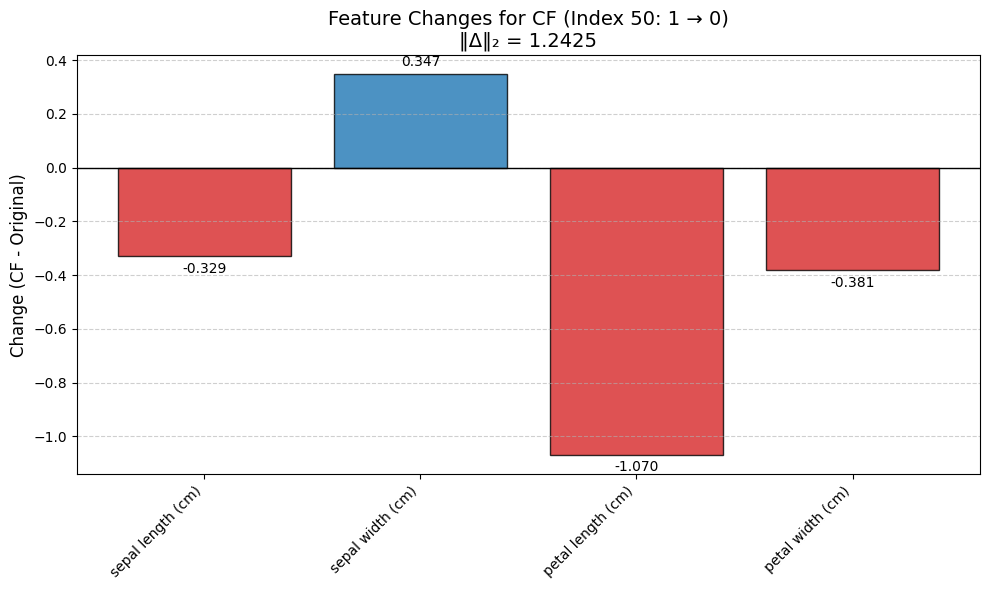

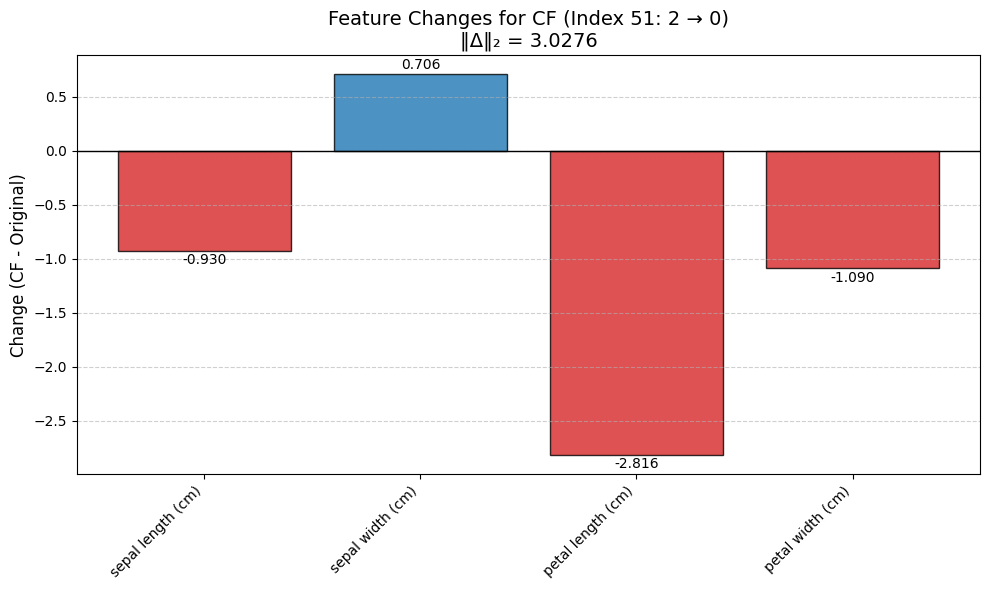

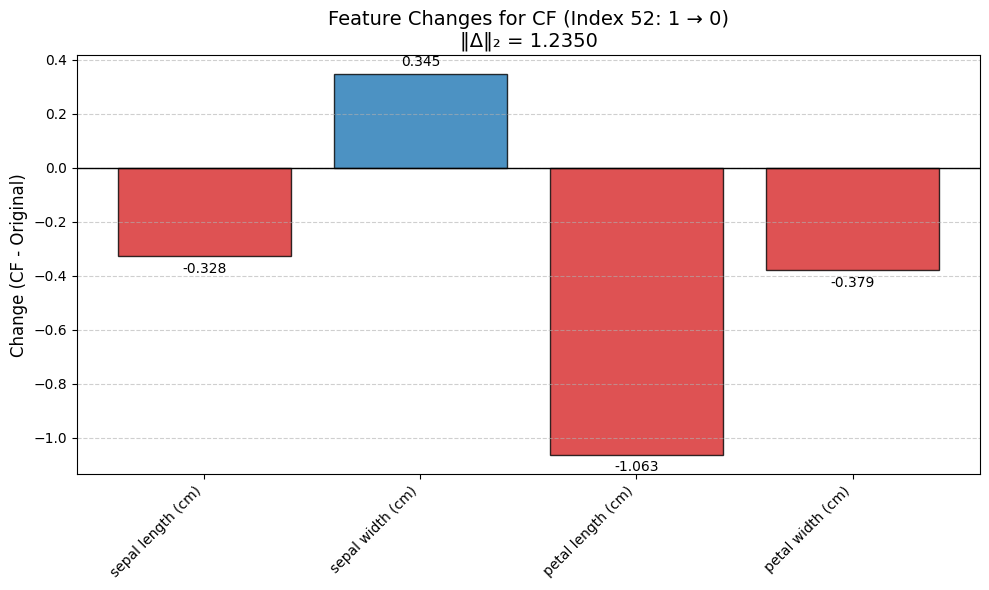

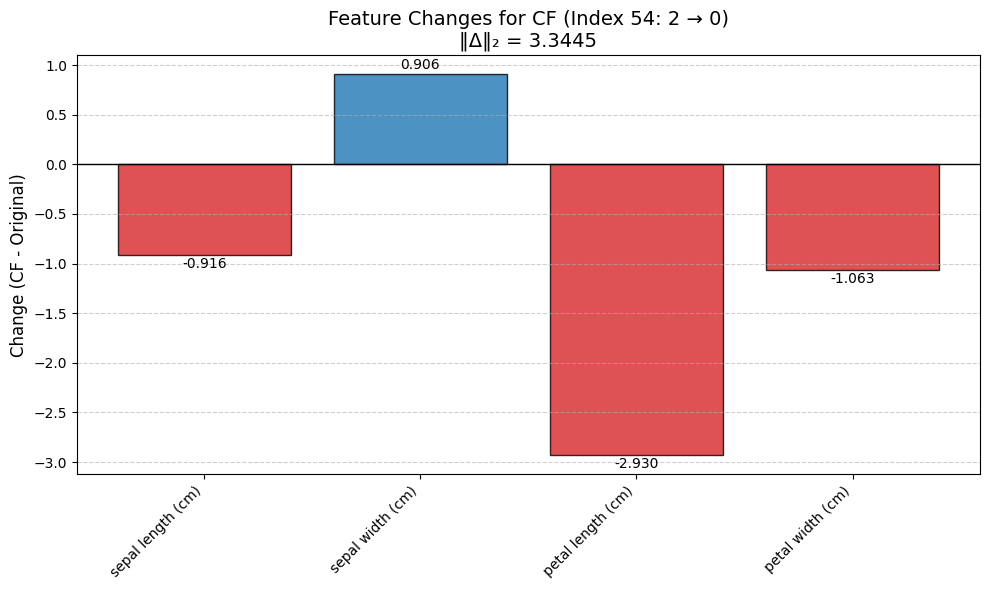

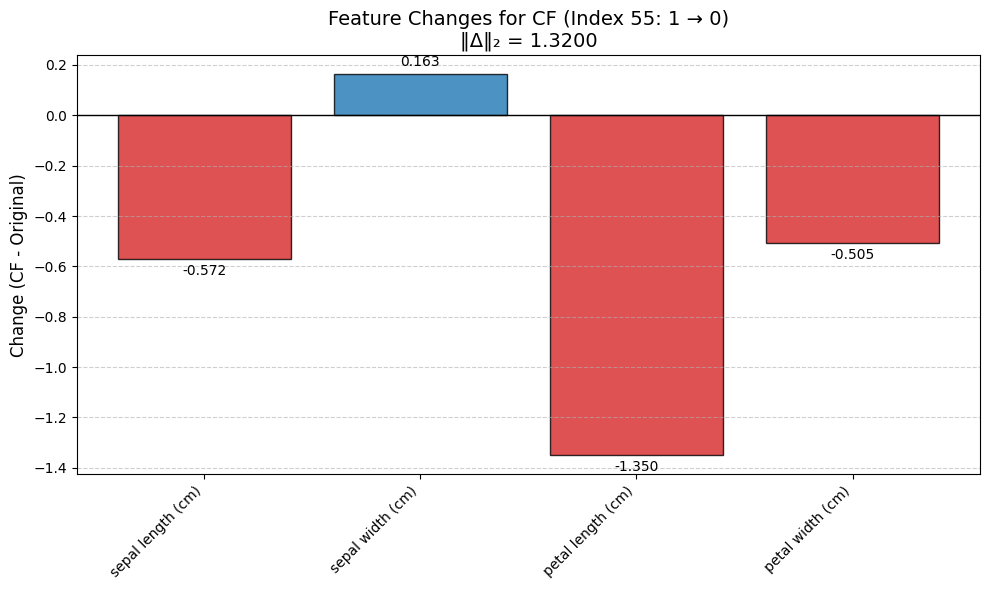

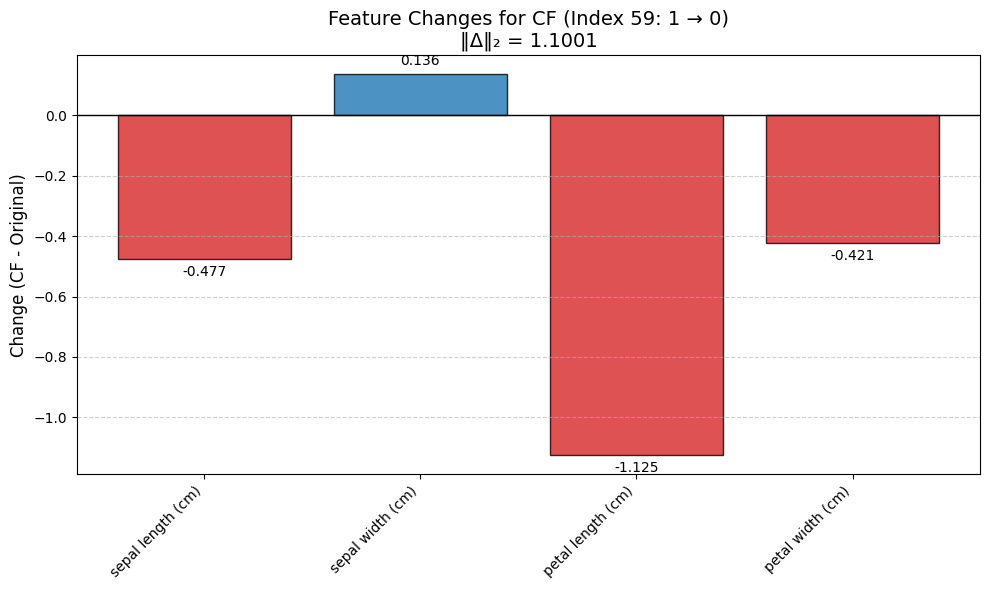

In [5]:
cf_success = [entry for entry in cf_data if entry['y_cf'] != entry['y_orig']]
print(f"Visualizing {len(cf_success)} counterfactuals...")

for entry in cf_success:
    orig_vals = scaler.inverse_transform([entry['x_orig']])[0]
    cf_vals = scaler.inverse_transform([entry['x_cf']])[0]

    changes = cf_vals - orig_vals
    delta_norm = entry['delta_norm']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        feature_names,
        changes,
        color=['#1f77b4' if val >= 0 else '#d62728' for val in changes],
        edgecolor='black',
        alpha=0.8
    )

    plt.title(
        f"Feature Changes for CF (Index {entry['Index']}: {entry['y_orig']} → {entry['y_cf']})\n"
        f"‖Δ‖₂ = {delta_norm:.4f}",
        fontsize=14
    )
    plt.ylabel("Change (CF - Original)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.axhline(0, color='black', linewidth=1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Annotate bars with change values
    for bar, val in zip(bars, changes):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02 * np.sign(height),
            f"{val:.3f}",
            ha='center',
            va='bottom' if val >= 0 else 'top',
            fontsize=10
        )

    plt.tight_layout()
    plt.show()
